In [1]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-usgyigo1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-usgyigo1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=b88c99e688fe4ff32191eca0aca0569cf0af07d43bc5095a30425f2e2b9d0a3a
  Stored in directory: /tmp/pip-ephem-wheel-cache-albs55aw/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything


In [95]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [96]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
!pip install -q monai

In [4]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage
from dataclasses import dataclass
import cv2
from PIL import Image

In [9]:
@dataclass(frozen=True)
class ImageResizeConfig:
    height: int = 1024
    width: int = 1024

In [10]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [11]:
@dataclass(frozen=True)
class DatasetConfig:
    SEED_VALUE:  int = 41
    CUT_PLANE:   str = "sagital"

    DATA_ROOT_TARGET:  str = f'/home/jovyan/data/segmentation/autopet-min-{CUT_PLANE}' 
    DATA_ROOT_TRAIN:  str = DATA_ROOT_TARGET + '/Train' 
    DATA_ROOT_VALID:  str = DATA_ROOT_TARGET + '/Valid'
    DATA_ROOT_TEST:   str = DATA_ROOT_TARGET + '/Test'
    DATA_TEST_GT:     str = DATA_ROOT_TARGET + '/Test.csv'

In [183]:
all_img_patches = []

images_file_names = os.listdir(DatasetConfig.DATA_ROOT_TRAIN+"/PET")

for img_name in images_file_names:
    img_path = f'{DatasetConfig.DATA_ROOT_TRAIN}/PET/{img_name}'
    large_image = cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (ImageResizeConfig.height, ImageResizeConfig.width))

    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):
            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

In [184]:
all_mask_patches = []

seg_file_names = os.listdir(DatasetConfig.DATA_ROOT_TRAIN+"/SEG")

for img_path in seg_file_names:
    img_path = f'{DatasetConfig.DATA_ROOT_TRAIN}/SEG/{img_name}'
    large_mask = np.asarray(cv2.resize(cv2.imread(img_path, cv2.IMREAD_GRAYSCALE), (ImageResizeConfig.height, ImageResizeConfig.width)))
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [185]:
images.shape

(5360, 256, 256)

In [186]:
masks.shape

(5360, 256, 256)

In [187]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (335, 256, 256)
Mask shape: (335, 256, 256)


In [188]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [189]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 335
})

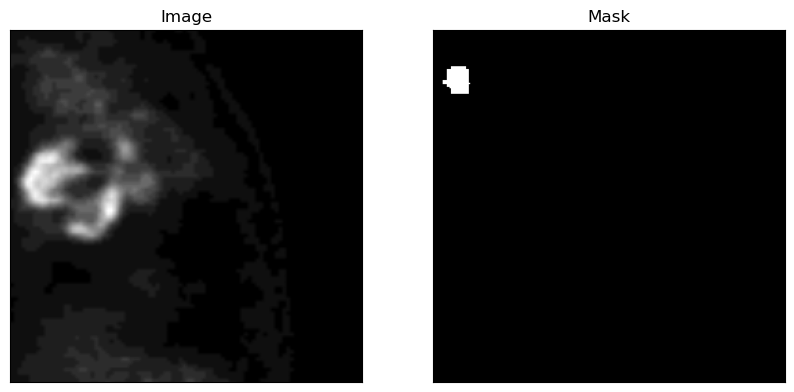

In [190]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [191]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [234]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    # image = np.array(Image.open(item["image"]).convert("RGB"))
    image = cv2.cvtColor(np.array(item["image"]),cv2.COLOR_GRAY2RGB)
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # print(np.array(image).shape)
    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [235]:
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [236]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [237]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [238]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [239]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [240]:
batch["ground_truth_mask"].shape

torch.Size([2, 256, 256])

In [241]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [242]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [243]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:36<00:00,  4.64it/s]


EPOCH: 0
Mean loss: 0.3549048864238319


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:34<00:00,  4.87it/s]


EPOCH: 1
Mean loss: 0.16126082327571653


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:35<00:00,  4.72it/s]


EPOCH: 2
Mean loss: 0.09769466645749551


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:34<00:00,  4.92it/s]


EPOCH: 3
Mean loss: 0.06859059815871574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:35<00:00,  4.78it/s]


EPOCH: 4
Mean loss: 0.05197834138137599


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:34<00:00,  4.87it/s]


EPOCH: 5
Mean loss: 0.04174660611897707


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:35<00:00,  4.76it/s]


EPOCH: 6
Mean loss: 0.03547323446366049


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:34<00:00,  4.93it/s]


EPOCH: 7
Mean loss: 0.030675721011080202


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:35<00:00,  4.67it/s]


EPOCH: 8
Mean loss: 0.02710119528429849


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:35<00:00,  4.73it/s]

EPOCH: 9
Mean loss: 0.024196448564041583


In [244]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "./checkpoints/model_checkpoint.pth")

# Inference

In [245]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [246]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("./checkpoints/model_checkpoint.pth"))

<All keys matched successfully>

In [247]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

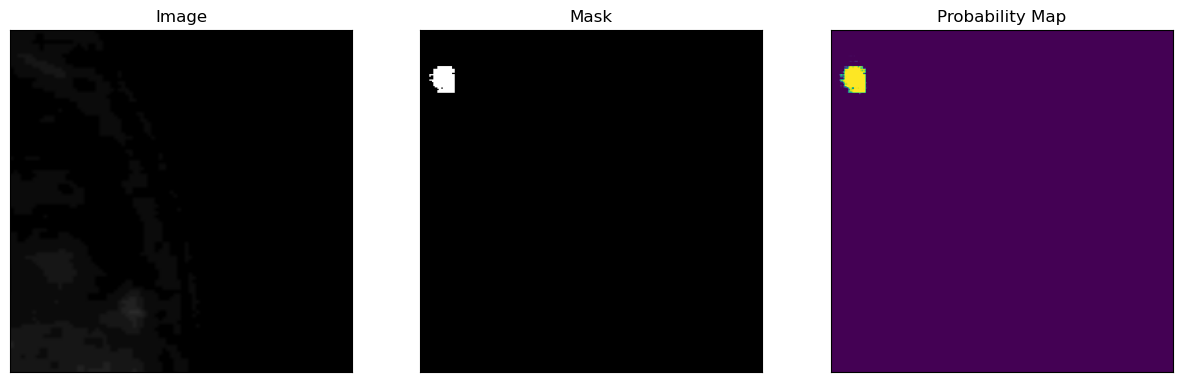

In [268]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
# test_image = dataset[idx]["image"] # had to convert images to RGB
test_image = cv2.cvtColor(np.array(dataset[idx]["image"]),cv2.COLOR_GRAY2RGB)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()